# Dataset Conversion to Sparse Matricies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse

In [2]:
from collections import Counter
from os.path import join, realpath

In [3]:
from matplotlib.patches import Rectangle

In [4]:
from mlbootcamp import rnd21
from mlbootcamp.rnd21.util import iou

## Load and Preprocess Data

In [5]:
train_data = pd.read_parquet('../../data/round/21/train_data.parquet')
train_ans = pd.read_parquet('../../data/round/21/train_ans.parquet')
test_data = pd.read_parquet('../../data/round/21/test_data.parquet')

## Multiple Markups of the Same Item

In both dataset and submission set there are duplicated records by pair user id and item id. It is important that there is only one such duplicate per dataset and submission set (two duplicates in total). We are intended to reveal origins of such duplicates, connection between markups and correct answer.

As we see below it seems that there are two bounding boxes on item. Each user who marked up the item marks exactely two bounding boxes i.e. there is not any other markups of the same item.

In [6]:
train_cnt = Counter([tuple(x) for x in train_data[['user_id', 'item_id']].values.tolist()])
train_idx = [x for x, y in train_cnt.most_common(10) if y > 1]
train_dups = train_data.set_index(['user_id', 'item_id']).loc[train_idx]
train_dups

x_min  y_min  x_max  y_max
user_id item_id                            
141     32          21    279    388    624
        32          42    799    128    881
366     32           9    321    387    638
        32          39    809    128    884
903     32          17    319    380    631
        32          41    809    126    883

In [7]:
len(train_data[train_data.item_id == 32])

6

The same is true for submission set.

In [8]:
test_cnt = Counter([tuple(x) for x in test_data[['user_id', 'item_id']].values.tolist()])
test_idx = [x for x, y in test_cnt.most_common(10) if y > 1]
test_dups = test_data.set_index(['user_id', 'item_id']).loc[test_idx]
test_dups

x_min  y_min  x_max  y_max
user_id item_id                            
1195    146         84    729    643   1091
        146         51    226    542    545
1383    146        120    735    602   1071
        146         83    231    506    528
422     146         45    757    634   1078
        146         17    250    535    534
1725    146        106    712    628   1118
        146         70    211    529    569

In [9]:
len(test_data[test_data.item_id == 146])

8

Now let's see how markups look like. Displayed boxes are obtained from user's markups as well as ground truth. Also there are rectangles which coordinates are mean coordinates over markups of the same user.

In [10]:
COLORMAP = plt.cm.Set1.colors
COLOURS = {}

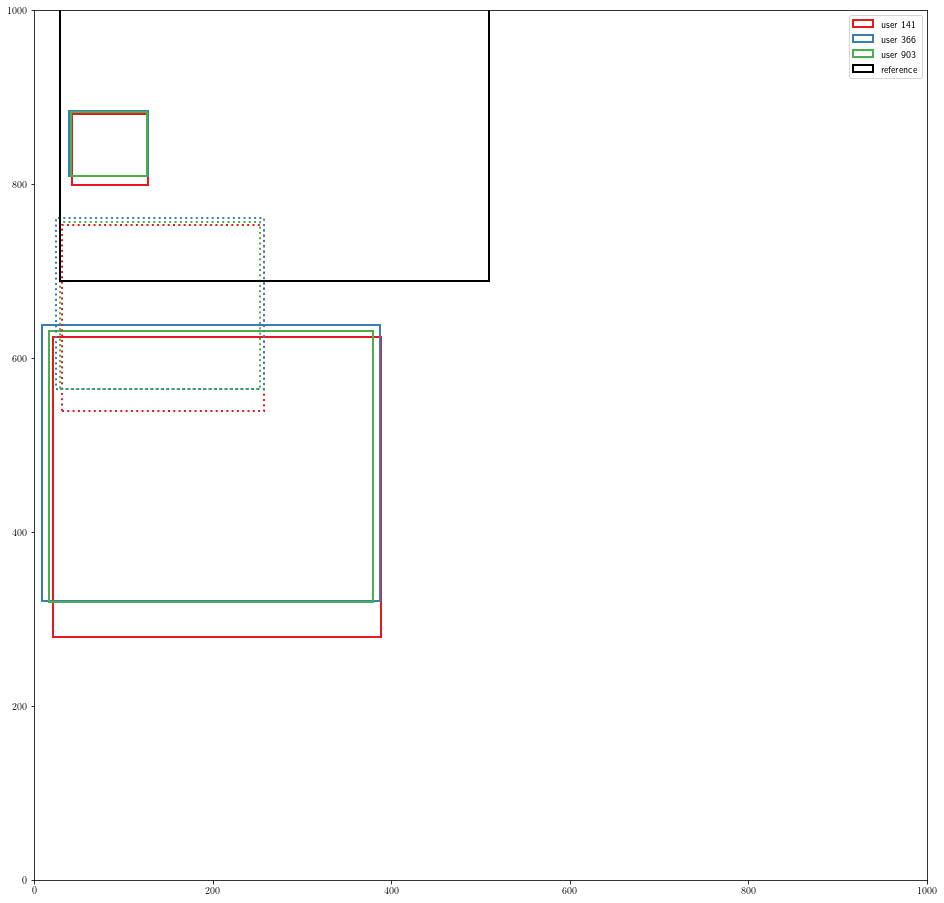

In [11]:
fig = plt.figure(figsize=(16, 16))
ax: plt.Axes  = fig.add_subplot(1, 1, 1)
ax.grid(False)

# Display rectangles in dataset.
for i, row in enumerate(train_dups.itertuples()):
    if row.Index[0] not in COLOURS:
        COLOURS[row.Index[0]] = COLORMAP[len(COLOURS)]
        label = f'user {row.Index[0]}'
    else:
        label = None

    origin = (row.x_min, row.y_min)
    width = row.x_max - row.x_min
    height = row.y_max - row.y_min

    ax.add_patch(Rectangle(origin, width, height,
         edgecolor=COLOURS[row.Index[0]],
         fill=False,
         label=label,
         linewidth=2,
    ))

# Display rectangles in dataset which are mean values by user.
for uid in train_dups.index.levels[0]:
    x_min, y_min, x_max, y_max = train_dups.loc[uid].values.mean(axis=0)
    origin = (x_min, y_min)
    width = x_max - x_min
    height = y_max - y_min

    ax.add_patch(Rectangle(origin, width, height,
        fill=False,
        edgecolor=COLOURS[uid],
        linestyle=':',
        linewidth=2,
    ))

# Display ground truth rectangle.
row = train_ans.loc[32]
origin = (row.x_min, row.y_min)
width = row.x_max - row.x_min
height = row.y_max - row.y_min

ax.add_patch(Rectangle(origin, width, height,
    fill=False,
    edgecolor='k',
    linewidth=2,
    label='reference',
))

ax.legend()
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
plt.show()

It seems that averaging is a good estimation for a markup of such items. So, we will drop duplicated rows below and insert averaged markups.

In [12]:
train_dups

x_min  y_min  x_max  y_max
user_id item_id                            
141     32          21    279    388    624
        32          42    799    128    881
366     32           9    321    387    638
        32          39    809    128    884
903     32          17    319    380    631
        32          41    809    126    883

In [13]:
train_data = train_data \
    .set_index(['user_id', 'item_id']) \
    .drop(index=train_dups.index.get_values()) \
    .reset_index()

In [14]:
train_avg = train_dups \
    .groupby('user_id') \
    .mean() \
    .astype(np.int32) \
    .reset_index()
train_avg['item_id'] = 32
train_avg = train_avg[train_avg.columns[[0, 5, 1, 2, 3, 4]]]

In [15]:
train_data = train_data.append(train_avg)

## Obtain Unique Identifiers of Items and Users

In [16]:
item_ids = np.array(list(set(train_data.item_id.values) | set(test_data.item_id.values)), dtype=np.int32)
item_ids.sort()
item_ids

array([    5,    10,    13, ..., 35966, 35973, 35978], dtype=int32)

In [17]:
user_ids = np.array(list(set(train_data.user_id.values) | set(test_data.user_id.values)), dtype=np.int32)
user_ids.sort()
user_ids

array([   0,    1,    2, ..., 1751, 1752, 1753], dtype=int32)

We need to map user id (item id) to index of row (column) of a sparse matrix.

In [18]:
uid2idx = {uid: idx for idx, uid in enumerate(user_ids)}
iid2idx = {iid: idx for idx, iid in enumerate(item_ids)}

## Convert Coorinates to Sparse Representation

Set multi-index on user id and item id for faster look up of ground truth bounding box which is required for IoU estimation.

In [19]:
train_ans = train_ans.set_index(['item_id'])
train_ans.sort_index(inplace=True)
train_ans.head()

,x_min,y_min,x_max,y_max
item_id,,,,
5,198,827,649,1340
10,26,605,433,847
13,233,698,622,920
30,61,368,329,530
32,30,536,328,813


Store indices which corresponds to objects from dataset and submission (subm) set.

In [20]:
dataset_indices = np.zeros((len(train_data), 2), dtype=np.int)
submset_indices = np.zeros((len(test_data), 2), dtype=np.int)

Use LiL matrices on building per each coordinate of bounding box. Also, use another one LiL matrix to store IoU score for each labeled object.

In [21]:
shape = (user_ids.size, item_ids.size)

xmin = sp.sparse.lil_matrix(shape, dtype=np.int32)
xmax = sp.sparse.lil_matrix(shape, dtype=np.int32)
ymin = sp.sparse.lil_matrix(shape, dtype=np.int32)
ymax = sp.sparse.lil_matrix(shape, dtype=np.int32)
ioum = sp.sparse.lil_matrix(shape, dtype=np.float)

Iterates over dataset rows and submission set rows and fill coordinates arrays.

In [22]:
for i, (_, (uid, iid, x_min, y_min, x_max, y_max)) in enumerate(train_data.iterrows()):
    dataset_indices[i, :] = (uid2idx[uid], iid2idx[iid])
    xmin[uid2idx[uid], iid2idx[iid]] = x_min
    xmax[uid2idx[uid], iid2idx[iid]] = x_max
    ymin[uid2idx[uid], iid2idx[iid]] = y_min
    ymax[uid2idx[uid], iid2idx[iid]] = y_max
    
    ground = train_ans.loc[iid].values
    ioum[uid2idx[uid], iid2idx[iid]] = iou((x_min, y_min, x_max, y_max), ground)

for i, (_, (uid, iid, x_min, y_min, x_max, y_max)) in enumerate(test_data.iterrows()):
    submset_indices[i, :] = (uid2idx[uid], iid2idx[iid])
    xmin[uid2idx[uid], iid2idx[iid]] = x_min
    xmax[uid2idx[uid], iid2idx[iid]] = x_max
    ymin[uid2idx[uid], iid2idx[iid]] = y_min
    ymax[uid2idx[uid], iid2idx[iid]] = y_max

In [23]:
xmin = xmin.tocsr()
ymin = ymin.tocsr()
xmax = xmax.tocsr()
ymax = ymax.tocsr()
ioum = ioum.tocsr()

## Save Data to Filesystem

In [24]:
OUTDIR = realpath('../../data/round/21')

Save sorted item ids and user ids.

In [25]:
np.save(join(OUTDIR, 'item-ids.npy'), item_ids)
np.save(join(OUTDIR, 'user-ids.npy'), user_ids)

Save indices of objects from both dataset and submission set.

In [26]:
np.save(join(OUTDIR, 'indices-dataset.npy'), dataset_indices)
np.save(join(OUTDIR, 'indices-submset.npy'), submset_indices)

Save coordinates of boxes as a sparse matrix.

In [27]:
sp.sparse.save_npz(join(OUTDIR, 'xmin.npz'), xmin)
sp.sparse.save_npz(join(OUTDIR, 'ymin.npz'), ymin)
sp.sparse.save_npz(join(OUTDIR, 'xmax.npz'), xmax)
sp.sparse.save_npz(join(OUTDIR, 'ymax.npz'), ymax)

Save values of IoU for each known object.

In [28]:
sp.sparse.save_npz(join(OUTDIR, 'ioum.npz'), ioum)